In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from rich import print

1) Corpus: The corpus type - one of GEN (general sarcasm), HYP (hyperbole), and RQ (rhetorical questions).

2) Label: The class label of the response utterance - one of "sarc" (sarcastic) or "notsarc" (not-sarcastic)

3) ID: A unique ID for the post. Pairs with the same ID numbers across different datasets are not related.

4) Text: The text of the post, annotated for sarcasm (i.e. the sarcasm label relates to this utterance).

## Load The Datasets

In [2]:
generic = pd.read_csv("../raw_data/GEN-sarc-notsarc.csv")
hyp = pd.read_csv("../raw_data/HYP-sarc-notsarc.csv")
rq = pd.read_csv("../raw_data/RQ-sarc-notsarc.csv")

print(f'Data sets shape:\nGeneric: {generic.shape[0]} records \nhyperbole: {hyp.shape[0]} records \nRhetorical questions: {rq.shape[0]} records.')

generic['sarcClass'] = 'generic'
hyp['sarcClass'] = 'hyp'
rq['sarcClass'] = 'rq'

sarcasm = pd.concat([generic, hyp, rq], axis=0)
print(f'Union Sarcasm dataset contains {sarcasm.shape[0]} records')

Data sets shape:
Generic: 6520 records 
hyperbole: 1164 records 
Rhetorical questions: 1702 records.

Union Sarcasm dataset contains 9386 records

### Sarcasm Distribution

In [3]:
print(rq['class'].value_counts())

class
notsarc    851
sarc       851
Name: count, dtype: int64

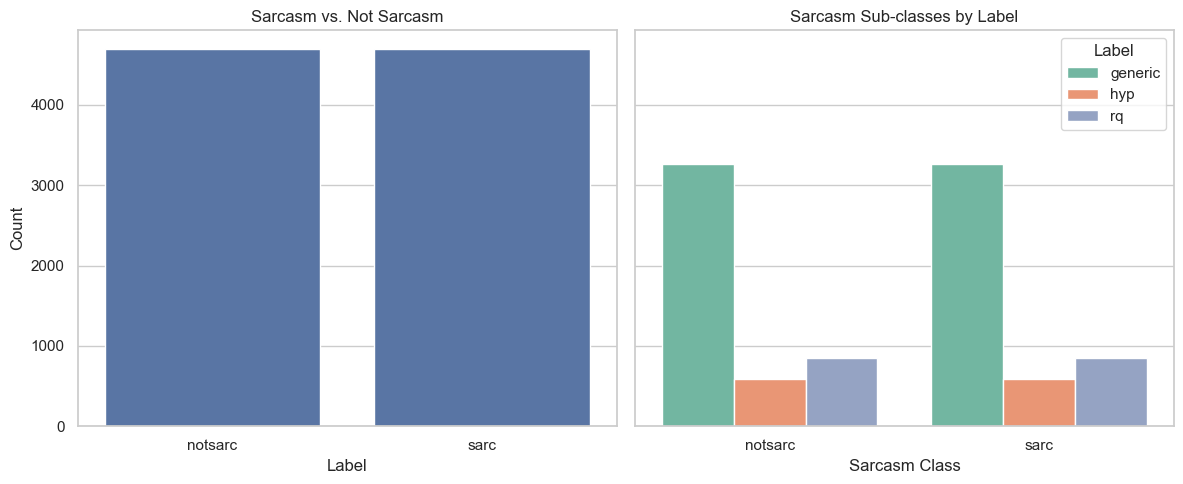

In [4]:
sns.set(style="whitegrid")

# --- Create subplots ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# --- 1. Binary label distribution ---
sns.countplot(data=sarcasm, x="class", ax=axes[0])
axes[0].set_title("Sarcasm vs. Not Sarcasm")
axes[0].set_xlabel("Label")
axes[0].set_ylabel("Count")

# --- 2. Sarcasm sub-classes ---
sns.countplot(data=sarcasm, x="class", hue="sarcClass", palette="Set2", ax=axes[1])
axes[1].set_title("Sarcasm Sub-classes by Label")
axes[1].set_xlabel("Sarcasm Class")
axes[1].set_ylabel("Count")
axes[1].legend(title="Label")

# --- Adjust layout ---
plt.tight_layout()
plt.show()

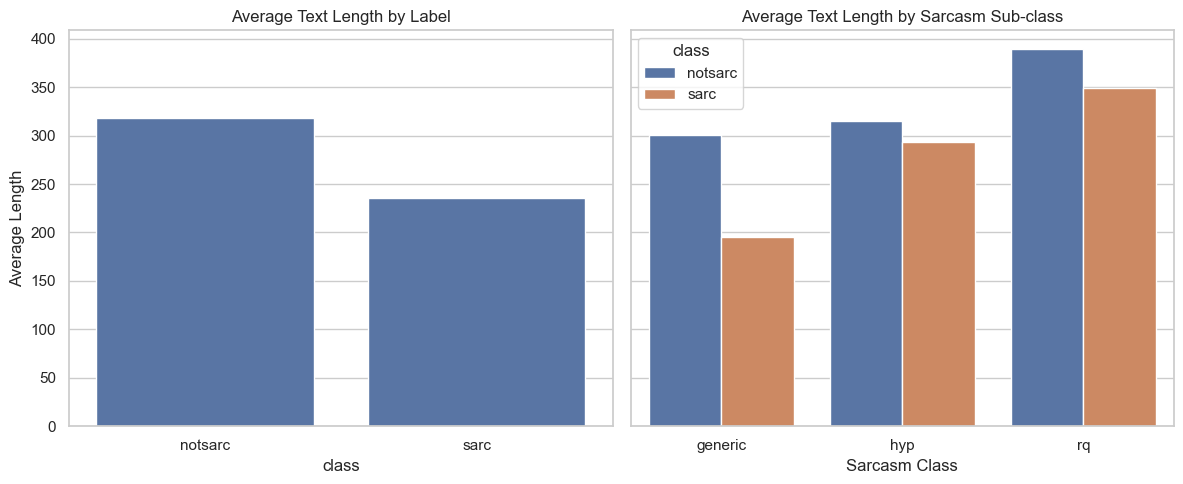

In [5]:
txt_len_df = sarcasm.copy()
txt_len_df['text_len'] = txt_len_df['text'].str.len()

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# --- 1. Average text length by label ---
avg_len_label = txt_len_df.groupby("class")["text_len"].mean().reset_index()
sns.barplot(data=avg_len_label, x="class", y="text_len", ax=axes[0])
axes[0].set_title("Average Text Length by Label")
axes[0].set_xlabel("class")
axes[0].set_ylabel("Average Length")

# --- 2. Average text length by sarcasm sub-class ---
avg_len_class = txt_len_df.groupby(["class", "sarcClass"])["text_len"].mean().reset_index()
sns.barplot(data=avg_len_class, x="sarcClass", hue="class", y="text_len", ax=axes[1])
axes[1].set_title("Average Text Length by Sarcasm Sub-class")
axes[1].set_xlabel("Sarcasm Class")
axes[1].set_ylabel("Average Length")

plt.tight_layout()
plt.show()

### Average words count

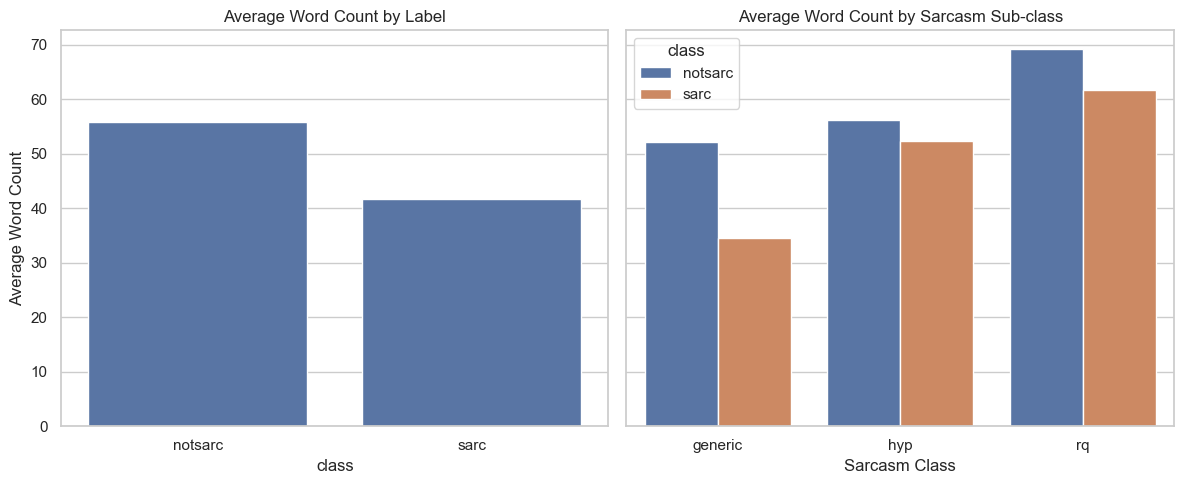

In [6]:
txt_len_df['word_count'] = txt_len_df['text'].apply(lambda x: len(str(x).split()))

# --- Create subplots ---
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# --- 1. Average word count by label ---
avg_words_label = txt_len_df.groupby("class")["word_count"].mean().reset_index()
sns.barplot(data=avg_words_label, x="class", y="word_count", ax=axes[0])
axes[0].set_title("Average Word Count by Label")
axes[0].set_xlabel("class")
axes[0].set_ylabel("Average Word Count")

# --- 2. Average word count by sarcasm sub-class ---
avg_words_class = txt_len_df.groupby(["class","sarcClass"])["word_count"].mean().reset_index()
sns.barplot(data=avg_words_class, x="sarcClass", hue="class", y="word_count", legend=True, ax=axes[1])
axes[1].set_title("Average Word Count by Sarcasm Sub-class")
axes[1].set_xlabel("Sarcasm Class")
axes[1].set_ylabel("Average Word Count")

plt.tight_layout()
plt.show()

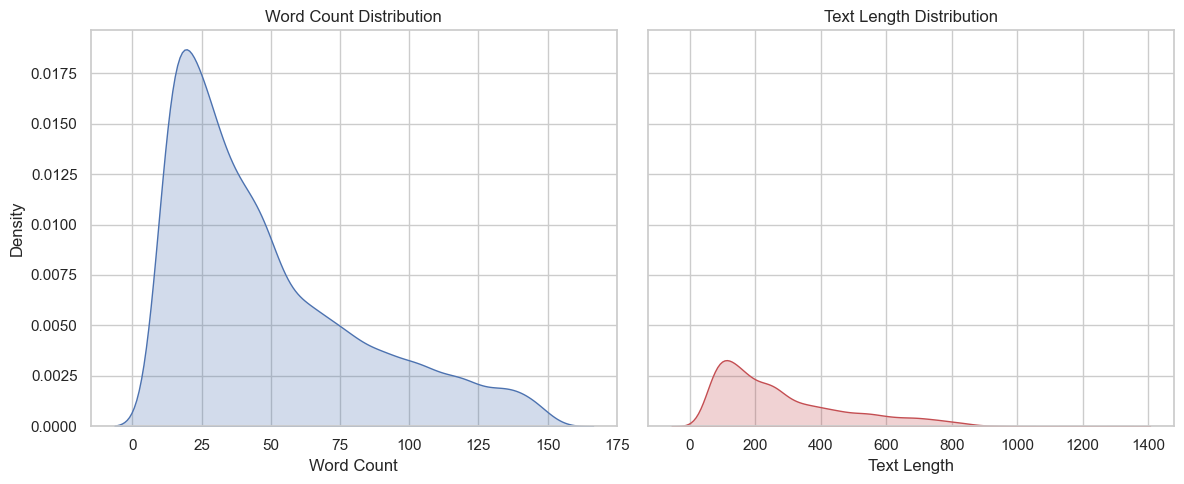

In [7]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(12, 5))

# Words count
sns.kdeplot(
    txt_len_df.word_count,
    fill=True,
    ax=axes[0],
)

# Text Length
sns.kdeplot(
    txt_len_df['text_len'],
    fill=True,
    ax=axes[1],
    color=sns.color_palette()[3]
)

axes[0].set_title("Word Count Distribution")
axes[0].set_xlabel("Word Count")
axes[1].set_title("Text Length Distribution")
axes[1].set_xlabel("Text Length")
plt.tight_layout()
plt.show()

In [8]:
# Sarcastic Words finder
from sklearn.feature_extraction.text import CountVectorizer

sarcastic_comments = sarcasm[sarcasm['class'] == 'sarc']['text']
vectorizer = CountVectorizer(ngram_range=(2,4), stop_words='english', min_df=5)
X = vectorizer.fit_transform(sarcastic_comments)

# Sum counts per n-gram
ngram_counts = X.sum(axis=0).A1
ngrams = vectorizer.get_feature_names_out()

# Put into DataFrame
ngram_freq = pd.DataFrame({'ngram': ngrams, 'count': ngram_counts})
ngram_freq = ngram_freq.sort_values('count', ascending=False)
ngram_freq.head()

,ngram,count
89,don know,91
272,oh wait,68
273,oh yeah,62
171,http www,52
102,don think,51


In [9]:
# Non- Sarcastic Words finder
non_sarcastic_comments = sarcasm[sarcasm['class'] == 'notsarc']['text']
vectorizer = CountVectorizer(ngram_range=(2, 4), stop_words='english', min_df=5)
X = vectorizer.fit_transform(non_sarcastic_comments)

# Sum counts per n-gram
ngram_counts = X.sum(axis=0).A1
ngrams = vectorizer.get_feature_names_out()

# Put into DataFrame
import pandas as pd

ngram_freq = pd.DataFrame({'ngram': ngrams, 'count': ngram_counts})
ngram_freq = ngram_freq.sort_values('count', ascending=False)
ngram_freq.head()

,ngram,count
163,don know,111
279,http www,108
175,don think,79
257,gun control,76
224,gay marriage,65


## Capital Letters ratio
Sarcastic against non sarcastic

In [34]:
def count_all_caps(txt):
    words = txt.split()
    all_caps = [w for w in words if len(w) > 2 and w.isupper()]
    return len(all_caps) / len(words)

txt_len_df['capitals_wrds'] = txt_len_df['text'].apply(count_all_caps)

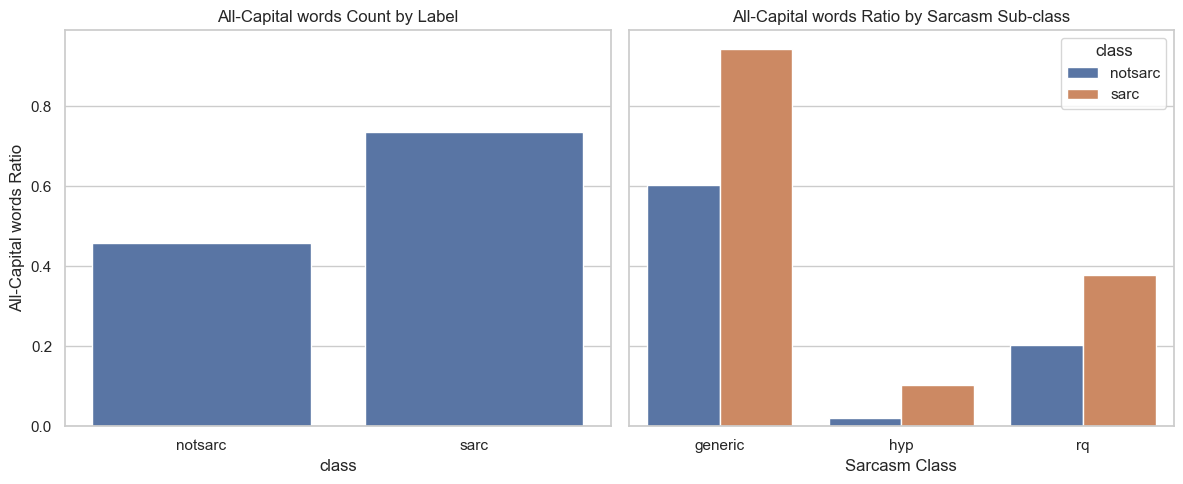

In [52]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# --- 1. Average word count by label ---
avg_words_label = pd.DataFrame(txt_len_df.groupby("class")["capitals_wrds"].mean()) * 100
sns.barplot(data=avg_words_label, x="class", y="capitals_wrds", ax=axes[0])
axes[0].set_title("All-Capital words Count by Label")
axes[0].set_xlabel("class")
axes[0].set_ylabel("All-Capital words Ratio")

# --- 2. Average word count by sarcasm sub-class ---
avg_words_class = pd.DataFrame(txt_len_df.groupby(["class","sarcClass"])["capitals_wrds"].mean()) * 100
sns.barplot(data=avg_words_class, x="sarcClass", hue="class", y="capitals_wrds", legend=True, ax=axes[1])
axes[1].set_title("All-Capital words Ratio by Sarcasm Sub-class")
axes[1].set_xlabel("Sarcasm Class")
axes[1].set_ylabel("All-Capital words Ratio")

plt.tight_layout()
plt.show()

## Panctuations ratio
Sarcastic against non sarcastic

In [95]:
import string
import re

def count_punc(txt):
    return len([ch for ch in txt if ch in string.punctuation])

def count_repeated_punc(txt):
    patterns = re.findall(r'([!?\']{2,})', txt)
    return len(patterns)

txt_len_df['punctuations'] = txt_len_df['text'].apply(count_punc)
txt_len_df['punctuations_patterns'] = txt_len_df['text'].apply(count_repeated_punc)


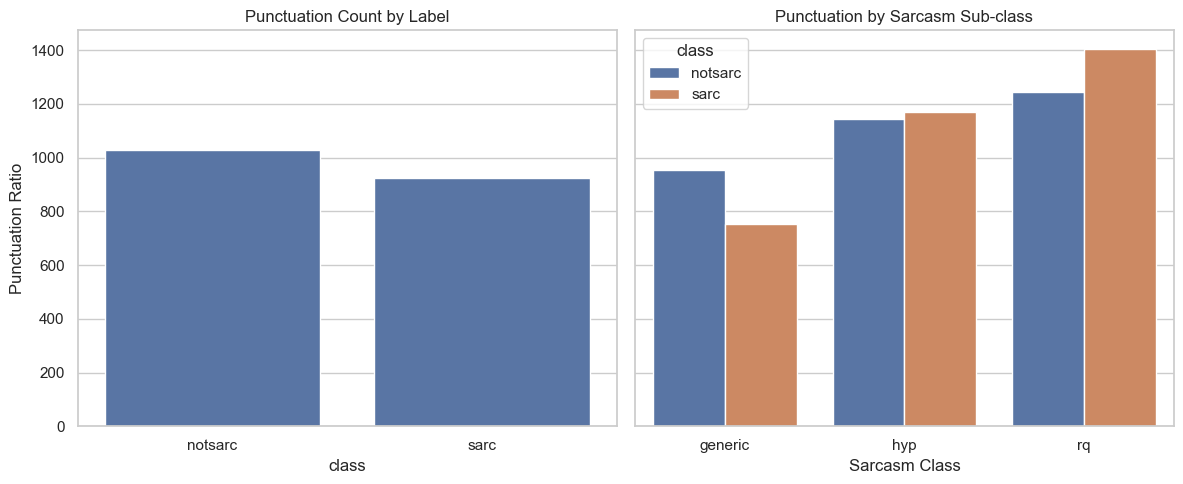

In [98]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# --- 1. Average word count by label ---
avg_words_label = pd.DataFrame(txt_len_df.groupby("class")["punctuations"].mean()) * 100
sns.barplot(data=avg_words_label, x="class", y="punctuations", ax=axes[0])
axes[0].set_title("Punctuation Count by Label")
axes[0].set_xlabel("class")
axes[0].set_ylabel("Punctuation Ratio")

# --- 2. Average word count by sarcasm sub-class ---
avg_words_class = pd.DataFrame(txt_len_df.groupby(["class","sarcClass"])["punctuations"].mean()) * 100
sns.barplot(data=avg_words_class, x="sarcClass", hue="class", y="punctuations", legend=True, ax=axes[1])
axes[1].set_title("Punctuation by Sarcasm Sub-class")
axes[1].set_xlabel("Sarcasm Class")
axes[1].set_ylabel("Punctuation Ratio")

plt.tight_layout()
plt.show()

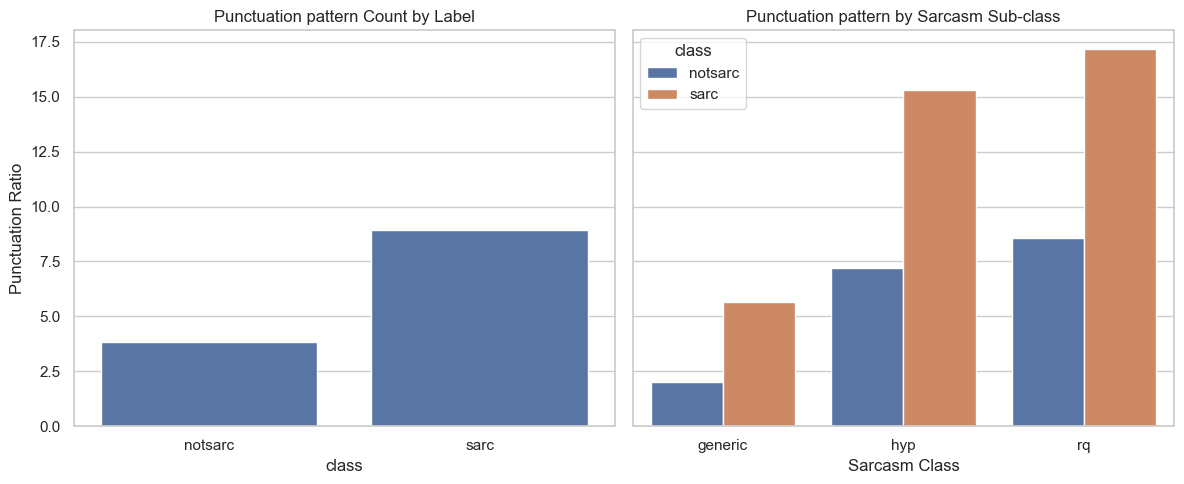

In [99]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# --- 1. Average word count by label ---
avg_words_label = pd.DataFrame(txt_len_df.groupby("class")["punctuations_patterns"].mean()) * 100
sns.barplot(data=avg_words_label, x="class", y="punctuations_patterns", ax=axes[0])
axes[0].set_title("Punctuation pattern Count by Label")
axes[0].set_xlabel("class")
axes[0].set_ylabel("Punctuation Ratio")

# --- 2. Average word count by sarcasm sub-class ---
avg_words_class = pd.DataFrame(txt_len_df.groupby(["class","sarcClass"])["punctuations_patterns"].mean()) * 100
sns.barplot(data=avg_words_class, x="sarcClass", hue="class", y="punctuations_patterns", legend=True, ax=axes[1])
axes[1].set_title("Punctuation pattern by Sarcasm Sub-class")
axes[1].set_xlabel("Sarcasm Class")
axes[1].set_ylabel("Punctuation Ratio")

plt.tight_layout()
plt.show()

In [118]:
txt_len_df[txt_len_df.reddit_jargon == True]

,class,id,text,sarcClass,text_len,word_count,capitals_wrds,punctuations,punctuations_patterns,reddit_jargon
81,notsarc,82,I'm not sure what you are saying. Are you sayi...,generic,969,145,0.000000,38,0,True
84,notsarc,85,The claim that only through a belief in the Bi...,generic,823,134,0.305970,46,1,True
565,notsarc,566,Directed variation seems unlikely:\r\n http://...,generic,199,14,0.000000,14,0,True
999,notsarc,1000,"Hello, please read http://www.reasons.org/reso...",generic,350,57,0.000000,21,0,True
1399,notsarc,1400,http://www.homeoffice.gov.uk/rds/pdfs2/hosb703...,generic,140,17,0.000000,13,0,True
1614,notsarc,1615,"Well, the 40Ar/39Ar method was used to say tha...",generic,374,59,0.000000,21,0,True
1731,notsarc,1732,The Brady Bill does not lower crime:http://jam...,generic,622,80,0.025000,47,0,True
2042,notsarc,2043,No I do not say that the creation of energy an...,generic,217,41,0.024390,4,0,True
2084,notsarc,2085,Microevolution has occured. Several times over...,generic,642,104,0.000000,27,0,True
2530,notsarc,2531,This baby was 21 weeks old. Here is 8 weeks ...,generic,101,11,0.000000,11,0,True


In [122]:
df = pd.DataFrame({'a': [[3,2,3],[4,5,3],[4,2,1]]})
df[['aa', 'ab', 'ac']] = df.a
df

,a,aa,ab,ac
0,"[3, 2, 3]",3,4,4
1,"[4, 5, 3]",2,5,2
2,"[4, 2, 1]",3,3,1


In [123]:
R = range(0, 768)
features = [f'feat{i}' for i in range(1, 769)]


In [125]:
len(R), len(features)

(768, 768)